# Deep Learning Project

- This is a Colab notebook for the final project of the KHU 'Deep Learning(CSE331-00)' course
- This notebook is the baseline, which provides basic guidelines and codes for project you need to solve.
- The deadline for the project is **June 14, 23:59**.
- If you have any questions, please do not hesitate to contact TA.
---

## Adversarial Learning
![FGSM](https://viso.ai/wp-content/uploads/2021/06/adversarial-machine-learning-example-FGSM.jpg)

Adversarial learning is a machine learning method that aims to trick machine learning models by providing deceptive input. Hence, it includes both the generation and detection of adversarial examples, which are inputs specially created to deceive classifiers.

One of the first and most popular adversarial attacks to date is referred to as the Fast Gradient Sign Attack (FGSM). It is designed to attack neural networks by leveraging the way they learn, gradients. The attack adjusts the input data to maximize the loss based on the same backpropagated gradients.

* You have to perform black box attack through an adversarial sample created by source model(ResNet)
* The baseline code is I-FGSM, and it is recommended to refer to other 'Adversarial attack' researchs to improve performance.
    * [I-FGSM](https://arxiv.org/pdf/1607.02533.pdf?utm_sourcesciontist.com&utm_mediumrefer&utm_campaignpromote): Kurakin, A., Goodfellow, I. J., & Bengio, S. (2018). Adversarial examples in the physical world.
    * [MI-FGSM](https://openaccess.thecvf.com/content_cvpr_2018/papers/Dong_Boosting_Adversarial_Attacks_CVPR_2018_paper.pdf): Dong, Y., Liao, F., Pang, T., Su, H., Zhu, J., Hu, X., & Li, J. (2018). Boosting adversarial attacks with momentum.
    * [TI-FGSM](https://openaccess.thecvf.com/content_CVPR_2019/papers/Dong_Evading_Defenses_to_Transferable_Adversarial_Examples_by_Translation-Invariant_Attacks_CVPR_2019_paper.pdf): Dong, Y., Pang, T., Su, H., & Zhu, J. (2019). Evading defenses to transferable adversarial examples by translation-invariant attacks.
    * [DI-FGSM](https://openaccess.thecvf.com/content_CVPR_2019/papers/Xie_Improving_Transferability_of_Adversarial_Examples_With_Input_Diversity_CVPR_2019_paper.pdf): Xie, C., Zhang, Z., Zhou, Y., Bai, S., Wang, J., Ren, Z., & Yuille, A. L. (2019). Improving transferability of adversarial examples with input diversity.


---
## Evaluation
- Metric: Accuracy
- Create **'submission.csv'** and your own **Colab notebook or .py file** then submit it to TA
    - Submission example: submission.csv, DL-Project.ipynb (zip the files and rename it to "STUDENT_ID_NAME". ex.2023315110_JINYEOBKIM)
    - E-mail: sifhy168@gmail.com and wls2074@khu.ac.kr

- It can be downloaded to 'File' > 'Download' > '.ipynb Download' at the top of the Colab notebook

<div>
<img src="https://www.notion.so/image/https%3A%2F%2Fprod-files-secure.s3.us-west-2.amazonaws.com%2F79c40b22-24a8-4f42-b27c-09cb5cb721ca%2Ff2a2305b-b806-46d3-a37c-7d81316878d7%2F%25E1%2584%2589%25E1%2585%25B3%25E1%2584%258F%25E1%2585%25B3%25E1%2584%2585%25E1%2585%25B5%25E1%2586%25AB%25E1%2584%2589%25E1%2585%25A3%25E1%2586%25BA_2023-12-04_%25E1%2584%258B%25E1%2585%25A9%25E1%2584%258C%25E1%2585%25A5%25E1%2586%25AB_7.07.06.png?table=block&id=94abb41b-c3a2-4ef2-9154-38bd219fec71&spaceId=79c40b22-24a8-4f42-b27c-09cb5cb721ca&width=2000&userId=9b171d95-14c1-4887-82b9-c7e38516fa74&cache=v2" width="500"/>
</div>


In [ ]:
import os
import math
import csv
import pickle
from urllib import request
import scipy.stats as st

import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.autograd as autograd
import torchvision
from torchvision import datasets, models, transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from sklearn.metrics import accuracy_score

device = torch.device("cuda:0")

# Data Loading & Modules

In [ ]:
import gdown
ids = [
    '1XHEWIiTv9Czjn9RJ6IHu_fWXfrteks5l',
    '1gwa_5bTO3dchDlC3WZ3nt_0VvwBkvFfi',
    '1DCUuuy20k-dNbUnCyi0HI9O7qy8hOpE5'
]

outputs = [
    'train.csv',
    'test.csv',
    'img.zip'
]

for i, o in zip(ids, outputs):
    gdown.download(id=i, output=o, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1XHEWIiTv9Czjn9RJ6IHu_fWXfrteks5l
To: /content/train.csv
100%|██████████| 20.7k/20.7k [00:00<00:00, 22.0MB/s]
Downloading...
From: https://drive.google.com/uc?id=1gwa_5bTO3dchDlC3WZ3nt_0VvwBkvFfi
To: /content/test.csv
100%|██████████| 5.21k/5.21k [00:00<00:00, 15.2MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=1DCUuuy20k-dNbUnCyi0HI9O7qy8hOpE5
From (redirected): https://drive.google.com/uc?id=1DCUuuy20k-dNbUnCyi0HI9O7qy8hOpE5&confirm=t&uuid=97151714-2dbc-46fd-a319-8c3094ced0e8
To: /content/img.zip
100%|██████████| 154M/154M [00:00<00:00, 187MB/s]


In [ ]:
!unzip -qq "/content/img.zip"

In [ ]:
##load image metadata (Image_ID, true label, and target label)
def load_ground_truth(fname):
    image_id_list = []
    label_ori_list = []
    label_tar_list = []

    df = pd.read_csv(fname)
    for _, row in df.iterrows():
        image_id_list.append( row['ImageId'] )
        label_ori_list.append( int(row['TrueLabel']) - 1 )
        label_tar_list.append( int(row['TargetClass']) - 1 )
    gt = pickle.load(request.urlopen('https://gist.githubusercontent.com/yrevar/6135f1bd8dcf2e0cc683/raw/d133d61a09d7e5a3b36b8c111a8dd5c4b5d560ee/imagenet1000_clsid_to_human.pkl'))
    return image_id_list,label_ori_list,label_tar_list, gt

## simple Module to normalize an image
class Normalize(nn.Module):
    def __init__(self, mean, std):
        super(Normalize, self).__init__()
        self.mean = torch.Tensor(mean)
        self.std = torch.Tensor(std)
    def forward(self, x):
        return (x - self.mean.type_as(x)[None,:,None,None]) / self.std.type_as(x)[None,:,None,None]

# Training

In [ ]:
norm = Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
trn = transforms.Compose([transforms.ToTensor(),])
ids, origins, targets, gt = load_ground_truth('train.csv')

batch_size = 10
max_iterations = 271
input_path = 'images/'
epochs = int(np.ceil(len(ids) / batch_size))

img_size = 299
lr = 0.5/255 #step size
epsilon = 16 # L_inf norm bound

In [ ]:
resnet = models.resnet50(weights="IMAGENET1K_V1").eval()
vgg = models.vgg16_bn(weights="IMAGENET1K_V1").eval()

for param in resnet.parameters():
    param.requires_grad = False
for param in vgg.parameters():
    param.requires_grad = False

resnet.to(device)
vgg.to(device)

torch.manual_seed(42)
torch.backends.cudnn.deterministic = True

Downloading: "https://download.pytorch.org/models/vgg16_bn-6c64b313.pth" to /root/.cache/torch/hub/checkpoints/vgg16_bn-6c64b313.pth
100%|██████████| 528M/528M [00:08<00:00, 65.1MB/s]


In [ ]:
preds_ls = []
labels_ls =[]
origin_ls = []
def input_diversity(image, prob=0.5, size_range=(299, 330)):
    """Applies random resizing and padding with a given probability."""
    if np.random.rand() < prob:
        rnd = np.random.randint(*size_range)
        rescaled = F.interpolate(image, size=(rnd, rnd), mode='bilinear', align_corners=False)
        pad_top = np.random.randint(0, size_range[1] - rnd)
        pad_bottom = size_range[1] - rnd - pad_top
        pad_left = np.random.randint(0, size_range[1] - rnd)
        pad_right = size_range[1] - rnd - pad_left
        padded = F.pad(rescaled, [pad_left, pad_right, pad_top, pad_bottom], mode='constant', value=0)
        return padded
    return image

# Parameters for DI-FGSM
p = 0.81735
  # Probability to apply transformation
size_range = (299, 330)
torch.cuda.empty_cache()
for k in tqdm(range(epochs), total=epochs):
    batch_size_cur = min(batch_size, len(ids) - k * batch_size)
    X_ori = torch.zeros(batch_size_cur, 3, img_size, img_size).to(device)
    delta = torch.zeros_like(X_ori, requires_grad=True).to(device)
    momentum = torch.zeros_like(delta)
    decay_factor = 0.75978
    for i in range(batch_size_cur):
        X_ori[i] = trn(Image.open(input_path + ids[k * batch_size + i] + '.png'))
    ori_idx = origins[k * batch_size:k * batch_size + batch_size_cur]
    labels = torch.tensor(targets[k * batch_size:k * batch_size + batch_size_cur]).to(device)

    for t in range(max_iterations):
        transformed_input = input_diversity(X_ori + delta, prob=p, size_range=size_range)
        # Calculate logits and loss
        logits = resnet(norm(transformed_input))
        loss = nn.CrossEntropyLoss(reduction='sum')(logits, labels)
        loss.backward()

        # Update delta with gradient information
        grad= delta.grad.clone()
        grad_norm = torch.norm(grad, p=2)  # L2 노름으로 정규화
        momentum = decay_factor * momentum + grad / grad_norm  # Momentum 업데이트

        delta.data = delta.data - lr * torch.sign(momentum)
        delta.data = delta.data.clamp(-epsilon / 255, epsilon / 255)
        delta.data = ((X_ori + delta.data).clamp(0, 1)) - X_ori
        delta.grad.zero_()

    X_pur = norm(X_ori + delta)
    preds = torch.argmax(vgg(X_pur), dim=1)

    preds_ls.append(preds.cpu().numpy())
    labels_ls.append(labels.cpu().numpy())
    origin_ls.append(ori_idx)


100%|██████████| 80/80 [58:35<00:00, 43.95s/it]


# Evaluation
* **Save the created data frame as csv, download and submit it**
* Explore submission file by clicking on the 'Folder' shaped icon on the left tab of the Colab
* Right-click the submission.csv item and download it

<div>
<img src="https://www.notion.so/image/https%3A%2F%2Fprod-files-secure.s3.us-west-2.amazonaws.com%2F79c40b22-24a8-4f42-b27c-09cb5cb721ca%2Fd1aa9a27-80c9-4ef3-9019-8518e2d1e564%2F%25E1%2584%2589%25E1%2585%25B3%25E1%2584%258F%25E1%2585%25B3%25E1%2584%2585%25E1%2585%25B5%25E1%2586%25AB%25E1%2584%2589%25E1%2585%25A3%25E1%2586%25BA_2023-12-04_%25E1%2584%258B%25E1%2585%25A9%25E1%2584%258C%25E1%2585%25A5%25E1%2586%25AB_6.56.55.png?table=block&id=5b8c7e1a-9710-42c3-b8d4-da8eebca66e5&spaceId=79c40b22-24a8-4f42-b27c-09cb5cb721ca&width=2000&userId=9b171d95-14c1-4887-82b9-c7e38516fa74&cache=v2" width="500"/>
</div>



In [ ]:
df = pd.DataFrame({
    'origin': [a for b in origin_ls for a in b],
    'pred': [a for b in preds_ls for a in b],
    'label': [a for b in labels_ls for a in b]
})

In [ ]:
df.head()

,origin,pred,label
0,305,778,778
1,883,377,377
2,243,122,122
3,559,791,740
4,438,695,695


In [ ]:
accuracy_score(df['label'], df['pred'])

0.36

* This performance will not be reproduced with Colab. Please don't worry and do your best.


In [ ]:
df.to_csv('0.36.csv')

# Visualization

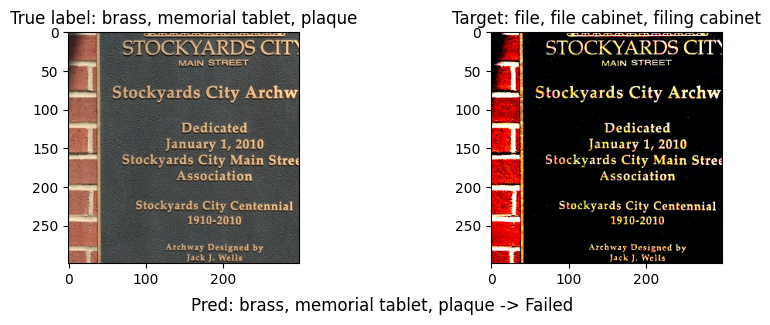

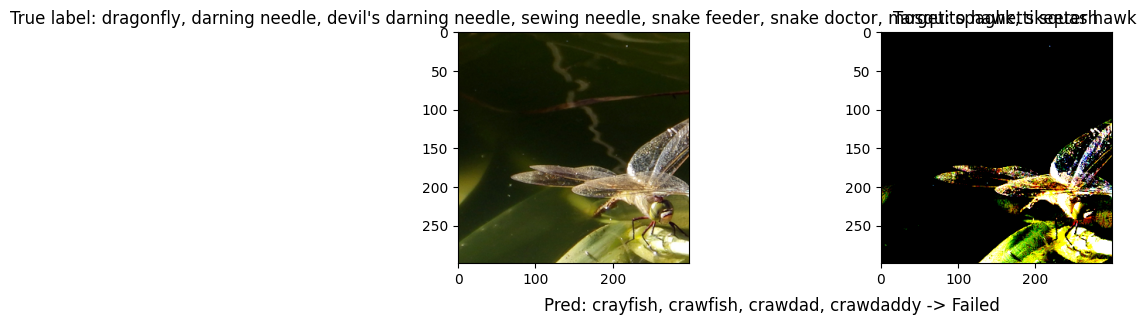

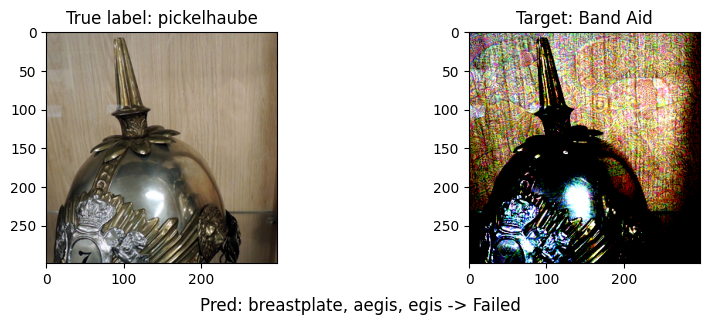

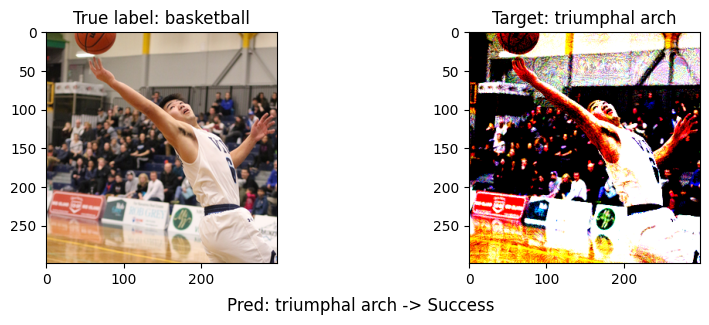

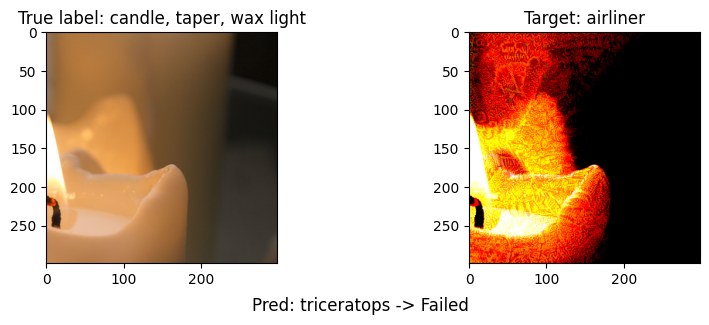

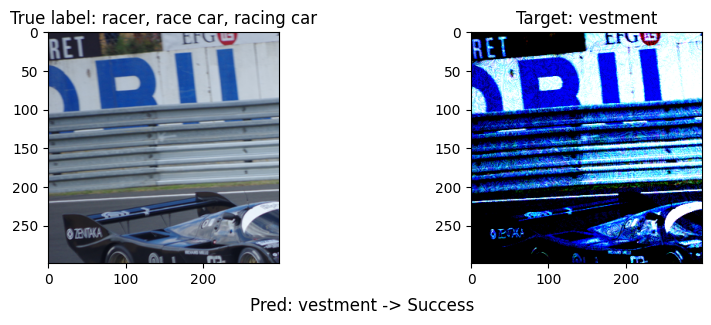

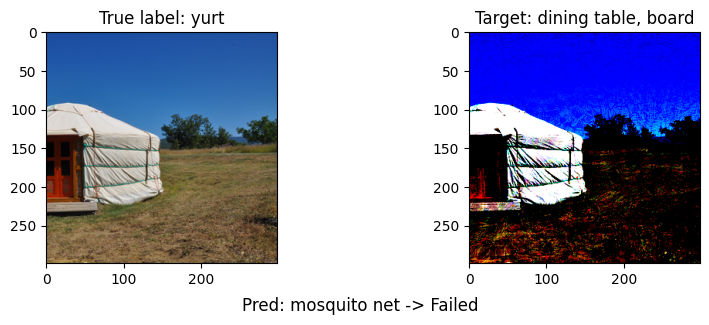

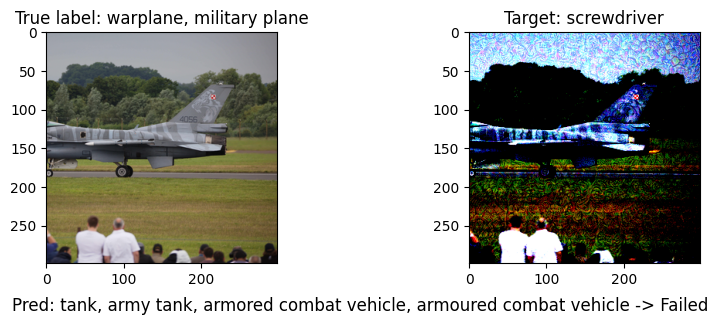

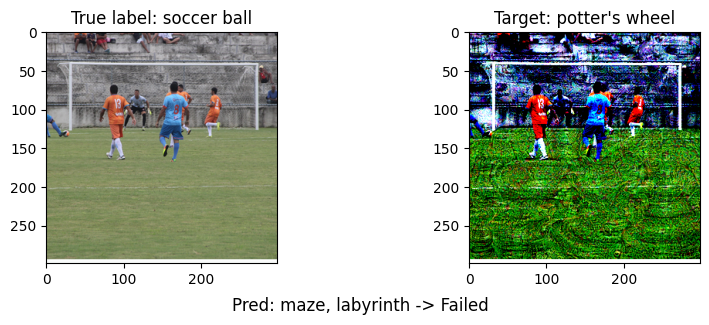

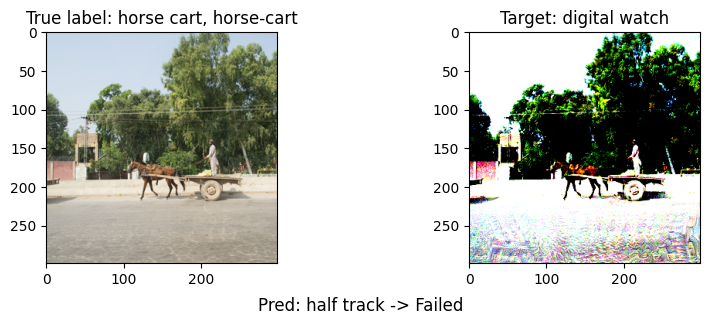

In [ ]:
def viz(img_A, img_B, origins, labels, gt, preds):
    for img_a, img_b, origin, label, pred in zip(img_A, img_B, origins, labels, preds):
        img_a = img_a.permute(1, 2, 0)
        img_b = img_b.permute(1, 2, 0)

        fig, (axA, axB) = plt.subplots(1, 2, figsize=(10,3))
        axA.imshow(img_a)
        axA.set_title("True label: " + gt[origin])
        axB.imshow(img_b)
        axB.set_title("Target: " + gt[label])

        result = 'Failed' if pred != label else 'Success'
        caption = f'Pred: {gt[pred]} -> {result}'
        fig.text(0.5, -0.05, caption, wrap=True, horizontalalignment='center', fontsize=12)

        plt.show()

viz(X_ori.cpu().detach(), X_pur.cpu().detach(), ori_idx, labels.cpu().numpy(), gt, preds.cpu().numpy())

In [ ]:
from google.colab import files
files.download('0.36.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>